# Setup

## Device

In [24]:
import torch

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# Data preparation

## Load data

In [25]:
from data import load_data

train_path = './data/train_data.csv'
test_path = './data/test_data.csv'

X_train_all, y_train_all = load_data(train_path, target='SalePrice')
X_test, _ = load_data(test_path)

X_train_all.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Preprocess data

### Split data

In [26]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)

print("Size of training set: ", X_train.shape)
print("Size of validation set: ", X_val.shape)

Size of training set:  (3299, 16)
Size of validation set:  (825, 16)


### Polynomial features

In [27]:
# from data import polynomial_expansion
# import numpy as np

# numeric_features = ['Floor', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
# numeric_features = X_train_all.select_dtypes(include=np.number).columns.tolist()

# X_train_poly = polynomial_expansion(X_train, numeric_features, degree=2)
# X_val_poly = polynomial_expansion(X_val, numeric_features, degree=2)

# X_train_poly.head()

### Categorical features

In [ ]:
from data import one_hot_encode

categorical_cols = X_train_all.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    X_train = one_hot_encode(X_train, col)
    X_val = one_hot_encode(X_val, col)
    X_test = one_hot_encode(X_test, col)

X_train.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


### Standardize numerical features

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Upsample minority classes

In [30]:
class_distribution = y_train.value_counts(normalize=True)
class_distribution

SalePrice
1    0.726887
2    0.140042
0    0.133071
Name: proportion, dtype: float64

In [31]:
# TODO: maybe use SMOTE?

# from imblearn.over_sampling import SMOTE
# import numpy as np

# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

# print("After SMOTE:", np.bincount(y_train))

### Datasets

In [32]:
class_weights = { 0: 1 / class_distribution[0], 1: 1 / class_distribution[1], 2: 1 / class_distribution[2] }

# TODO: remove

class_weights[0] *= 2
class_weights[2] *= 2

class_weights

{0: np.float64(15.029612756264235),
 1: np.float64(1.3757297748123436),
 2: np.float64(14.281385281385282)}

In [33]:
from data import to_dataloader

train_loader = to_dataloader(X_train, y_train.values, batch_size=1024, class_weights=class_weights)
val_loader = to_dataloader(X_val, y_val.values)

In [34]:
vector_size = X_train.shape[1]

print("Vector size: ", vector_size)

Vector size:  33


In [35]:
num_classes = len(class_distribution)

print("Number of classes: ", num_classes)

Number of classes:  3


# Model

In [36]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1, dropout: float = 0.2):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_size),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.seq(x)

# Experiments

In [37]:
def ordinal_loss(preds, targets):
    target1 = (targets > 0).float()
    target2 = (targets > 1).float()

    loss1 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.75))(preds[:, 0], target1)
    loss2 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2))(preds[:, 1], target2)

    return loss1 + loss2

Epoch  1/150 - Train Loss: 1.13 - Val Loss: 1.28 - Val Acc: 0.1491 - LR: 0.0001
Epoch  2/150 - Train Loss: 0.89 - Val Loss: 1.21 - Val Acc: 0.1491 - LR: 0.0001
Epoch  3/150 - Train Loss: 0.70 - Val Loss: 1.09 - Val Acc: 0.1612 - LR: 0.0001
Epoch  4/150 - Train Loss: 0.62 - Val Loss: 0.93 - Val Acc: 0.7103 - LR: 0.0001
Epoch  5/150 - Train Loss: 0.55 - Val Loss: 0.79 - Val Acc: 0.7612 - LR: 0.0001
Epoch  6/150 - Train Loss: 0.55 - Val Loss: 0.67 - Val Acc: 0.8048 - LR: 0.0001
Epoch  7/150 - Train Loss: 0.50 - Val Loss: 0.57 - Val Acc: 0.8267 - LR: 0.0001
Epoch  8/150 - Train Loss: 0.48 - Val Loss: 0.49 - Val Acc: 0.8267 - LR: 0.0001
Epoch  9/150 - Train Loss: 0.44 - Val Loss: 0.45 - Val Acc: 0.8339 - LR: 0.0001
Epoch 10/150 - Train Loss: 0.42 - Val Loss: 0.44 - Val Acc: 0.8267 - LR: 0.0001
Epoch 11/150 - Train Loss: 0.42 - Val Loss: 0.42 - Val Acc: 0.8352 - LR: 0.0001
Epoch 12/150 - Train Loss: 0.44 - Val Loss: 0.41 - Val Acc: 0.8436 - LR: 0.0001
Epoch 13/150 - Train Loss: 0.43 - Val Lo

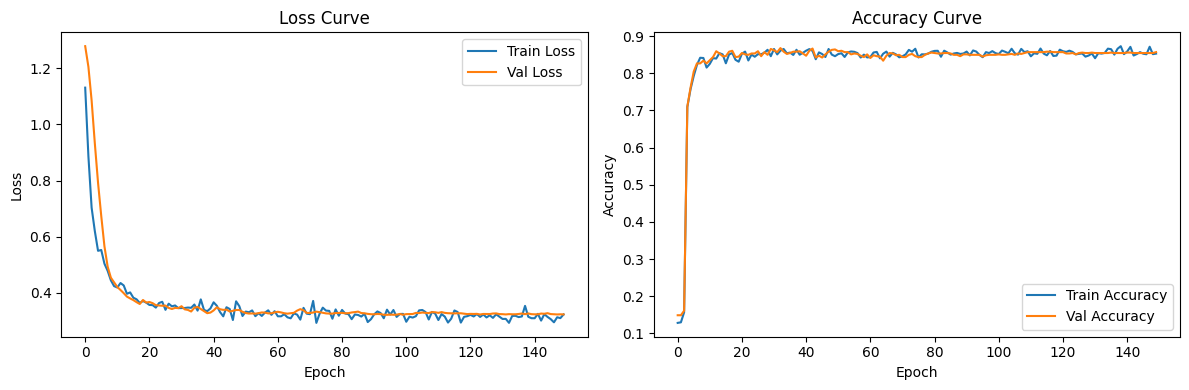

In [38]:
from train import Trainer

model = NeuralNetwork(input_size=vector_size, output_size=num_classes-1, dropout=0.1)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=2e-1)
criterion = ordinal_loss

trainer = Trainer(model)
trainer.to_device(device)
trainer.compile(optimizer=optim, criterion=criterion)

trainer.fit(train_loader, val_loader, epochs=150)

# Evaluation

In [39]:
from train import predict

y_pred = predict(model, X_val, device)

### Accuracy curve

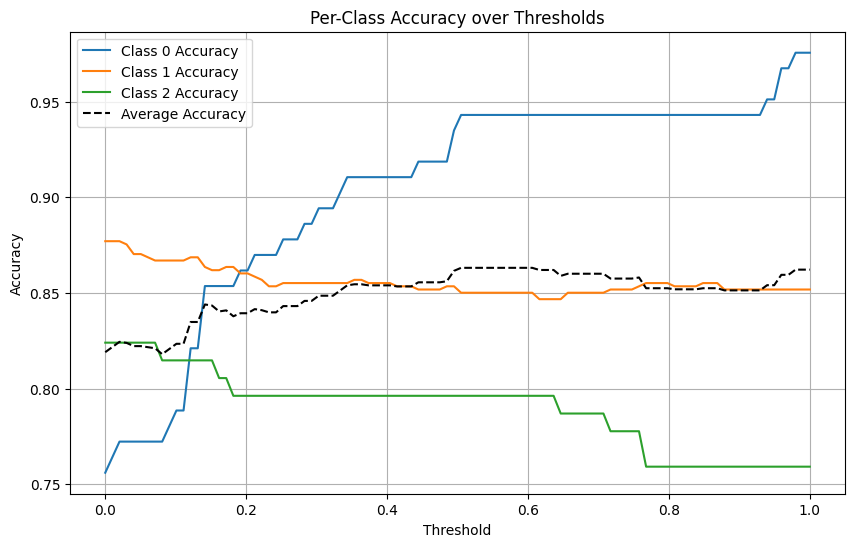

In [40]:
from plots import plot_acc_over_thresholds

plot_acc_over_thresholds(y_val, y_pred)

In [47]:
from utils import pred_to_class


pred_class = pred_to_class(y_pred, threshold=(0.6, 0.5)).numpy()

### Accuracy per class

Class 0 accuracy: 0.91
Class 1 accuracy: 0.84
Class 2 accuracy: 0.82
Average class accuracy: 0.86


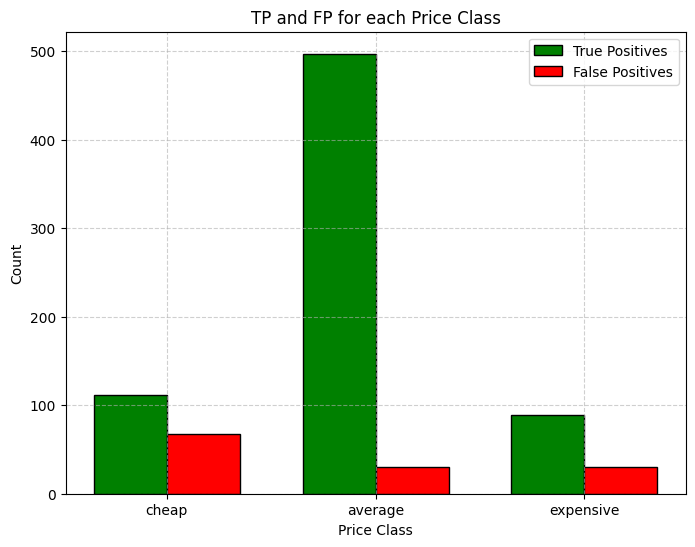

In [48]:
from plots import plot_pred_acc


plot_pred_acc(y_val, pred_class)

### Confusion matrix

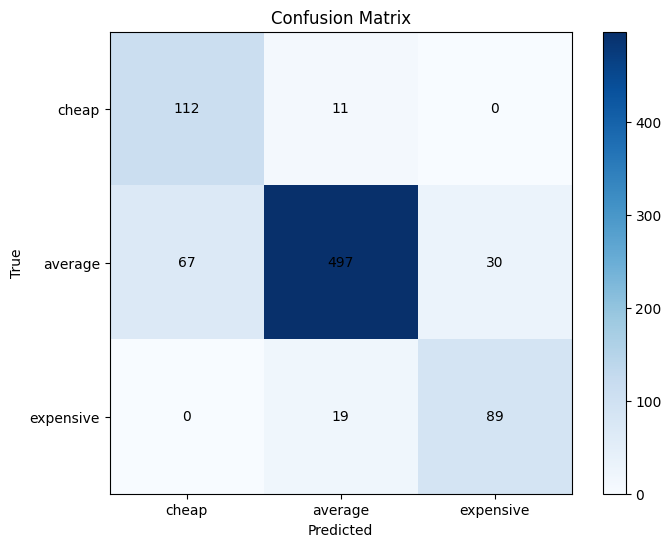

In [49]:
from plots import plot_confusion_matrix

plot_confusion_matrix(y_val, pred_class)